# Step 1: Write your Segmentation Algorithm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  You may add additional parameters besides the image to be segmented if you wish.  Your algorithm must use the random-walker segmentation (``skimage.segmentation.random_walker()``) and you should consider doing some region processing after segmentation to improve the result.

_Hint: The challenge here is to automatically find suitable foreground and background markers for the random walker algorithm.  The noisy images make for an additional challenge, but that's why we're using random walker; becuase of its robustness to noise._

_Hint: When you use `random_walker()` on a color image, make sure to set `multichannel=True`._


In [10]:
import skimage.util as util
import skimage.io as io
import numpy as np
import glob
import skimage.segmentation as seg
import skimage.filters as filt
import skimage.morphology as morph
import skimage.morphology.selem as selem
import os as os
import warnings
warnings.filterwarnings("ignore")

def segleaf(I):
    """
    Leaf segmentation using random walker
    :param I: Input image as a float

    :return: A binary image that shows the segmentation of the leaf from the background
    """
    #Separate the image into it's three colour components
    red = 255 * I[:, :, 0]
    green = 255 * I[:, :, 1]
    blue = 255 * I[:,:,2]

    #Create a new image with the amount of greeness exaggerrated
    greenness = 1.97 * green - red - blue
    #Find a threshold value
    T = filt.threshold_otsu(greenness)
    #Create an array of identical size to the image, with seed pixels labelled as fg and bg
    seeds = np.zeros_like(I, dtype=np.uint8)
    seeds[greenness >= T] = 1  # fg label
    try:
        seeds[greenness < 5] = 2  # bg label
        labels = seg.random_walker(I, seeds, beta=10, multichannel=True)
    except:
        #For when a IndexError occurs
        try:
            seeds[greenness < 10] = 2  # bg label
            labels = seg.random_walker(I, seeds, beta=10, multichannel=True)
        except:
            seeds[greenness < 22] = 2  # bg label
            labels = seg.random_walker(I, seeds, beta=10, multichannel=True)

    #Label the bg labelled pixels as False
    labels[labels == 2] = 0
    labels = labels[:,:,0]  #All three colour components share the same value now, so only one is needed.

    #Perform some region processing to improve the result
    labels = morph.opening(labels, selem.diamond(1))
    labels = morph.binary_closing(labels, selem.diamond(2.5))
    labels = morph.remove_small_objects(labels, 30)
    labels = morph.binary_closing(labels, selem.diamond(3))
    labels = morph.remove_small_objects(labels, 340)
    labels = morph.binary_closing(labels, selem.diamond(6))
    return labels

# Step 2: Write a Validation driver program.

Write code that segments each image, and computes the DSC for each segmentation.  Print the DSC of each segmentation as you perform it.  At the end, print the average of the DSC over all of the images. 

The general approach should be similar to Assignment 3.  For each input image (in the `images` folder):

* load the image and it's ground truth
* segment the input image 
* Compute the DSC from the segmented image and the ground truth image (this function is given below).
* Print the DSC to the console.

When finished, don't forget to print the average DSC for all images.  If you're getting a mean DSC of greater than 0.8, you're doing pretty good.

_Feel free to define additional helper functions for your program if you think it will help._

In [8]:
import skimage.util as util
import skimage.io as io
import numpy as np
import glob
import skimage.segmentation as seg
import skimage.filters as filt
import skimage.morphology as morph
import os as os
import warnings
warnings.filterwarnings("ignore")

def dice_coefficient(bwA, bwG):
    '''
    Dice coefficient between two binary images
    :param bwA: a binary (dtype='bool') image
    :param bwG: a binary (dtype='bool') image
    :return: the Dice coefficient between them
    '''
    intersection = np.logical_and(bwA, bwG)

    return 2.0*np.sum(intersection) / (np.sum(bwA) + np.sum(bwG))


def Driver():
    '''
    Performs the Random Walker Segmentation on each of the noisy image files and does a DSC comparison with each equivelent ground truth image
    :return: Nothing
    '''
    images = [os.path.basename(x) for x in glob.glob('noisyimages/*.png')]
    avD = 0
    length = len(images)
    for i in range(0,length):
        I = util.img_as_float(io.imread('noisyimages/' + images[i]))
        J = util.img_as_bool(io.imread('groundtruth/thresh' + images[i]))
        A = segleaf(I)
        dsc = dice_coefficient(A, J)
        print(images[i])
        print("DSC: ", dsc)
        if (dsc > 0.6):
            print("Recognized as a leaf")
        avD += dsc
    print("Average DSC: ", avD/length)

# Write your validation driver here.  It should be structured similarly to the driver in Assignment 3.

# Step 3:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the boundary of the segmentation superimposed on top (just like Step 4 in of assignment 3).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


Text(0.5, 1.0, 'Bad Result')

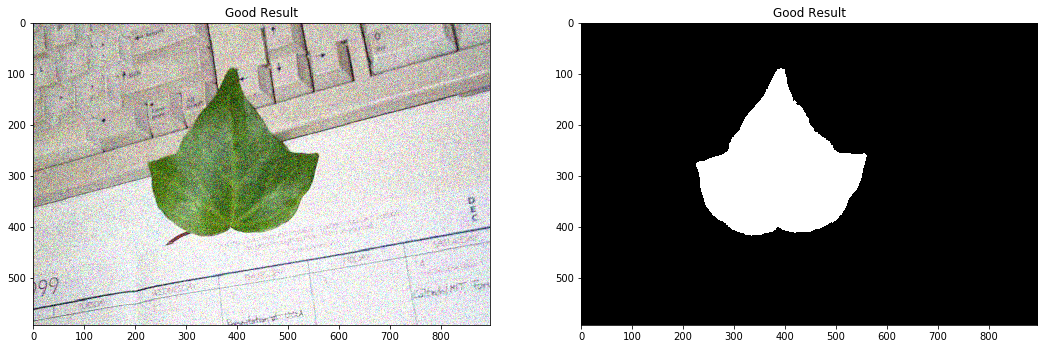

<Figure size 432x288 with 0 Axes>

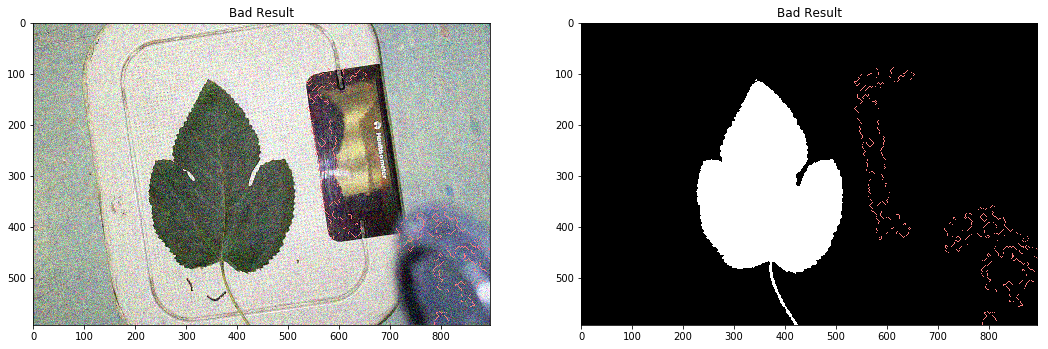

In [5]:
import matplotlib.pyplot as plt

% matplotlib inline

good = io.imread('noisyimages/image_0162.png')
bad = io.imread('noisyimages/image_0099.png')
good_gt = io.imread('groundtruth/threshimage_0162.png')
bad_gt = io.imread('groundtruth/threshimage_0099.png')

good_seg = segleaf(good)
bad_seg = segleaf(bad)

good_label = morph.label(good_seg)
bad_label = morph.label(bad_seg)

plt.subplots(1, 2, figsize=(18,6))
plt.subplot(121)
plt.imshow(seg.mark_boundaries(good, good_label, color=(1,.5,.5), mode='outer'))
plt.title('Good Result')
plt.subplot(122)
plt.imshow(seg.mark_boundaries(good_gt, good_label, color=(1,.5,.5), mode='outer'))
plt.title('Good Result')

plt.figure()
plt.subplots(1, 2, figsize=(18,6))
plt.subplot(121)
plt.imshow(seg.mark_boundaries(bad, bad_label, color=(1,.5,.5), mode='outer'))
plt.title('Bad Result')
plt.subplot(122)
plt.imshow(seg.mark_boundaries(bad_gt, bad_label, color=(1,.5,.5), mode='outer'))
plt.title('Bad Result')


# Step 4: Reflection

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	The image was separated into it's colour components. A new image was created that was the result of nearly doubling the green component in the image and then subtracting the red and green components from this. A 2d array of zeros was created with equal dimensions to the input float image. Using otsu's method a threshold was chosen for the foreground seeds. Background seeds were chosen as those pixel values that were very close to 0, becaue with the amount of green calculation used, and the fact that the backgrounds were mostly white, a value close to zero indicated this pixel was almost certainly part of the background. The random walker was able to label the other objects which were not the leaf as background based on how it traversed the edges of the graph for the image. The method used resulted in an overabundance of seeds, because many of the leaf pixels were over the declared foreground threshold, and thus were declared as seeds. This resulted in a patchy segementation of the leaf, which was corrected by using an opening and some closings in post-processing, using a diamond shaped selem to account for the sharp zig zap edges of most of the leaves. Small background spots in the segmentation were removed by alternating a closing with the function remove_small_objects, with increasing values so as to remove the larger background objects only when it was safe to do so without removing parts of the leaf.

2. Consider your good result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	The patchyness of my algorithm made it difficult to get entirely straight lines, as the openings and closings, skewed the edges. Using a threshold with a higher value would have made it so there were less foreground seeds, and made it more simple for the random walker to traverse the edge of the leaf, leading to straighter cut segmentation lines.

3. Consider your bad result.  What is it about your algoirthm caused the poor performance on this image?   If you weren't able to get any results, leave this blank.

	Noise, combined with the colour shades of gold and blue in picture appear to be the problem. It looks like random background pixels are being chosen as forground seeds and confusing the walker. From the line tracing, it looks like a larger erosion would be able to take away some of pixels incorrectly labelled as foreground, but this was not a general solution for all the pictures, so this solution was not used.


In [12]:
Driver()

image_0019.png
DSC:  0.9358186920311496
Recognized as a leaf
image_0018.png
DSC:  0.789867587795049
Recognized as a leaf
image_0009.png
DSC:  0.9616183408658346
Recognized as a leaf
image_0078.png
DSC:  0.902337252735236
Recognized as a leaf
image_0132.png
DSC:  0.6860895740217093
Recognized as a leaf
image_0090.png
DSC:  0.8962646168710305
Recognized as a leaf
image_0080.png
DSC:  0.9731489978981024
Recognized as a leaf
image_0110.png
DSC:  0.9447950019036206
Recognized as a leaf
image_0104.png
DSC:  0.8985809631880133
Recognized as a leaf
image_0105.png
DSC:  0.8533671893597671
Recognized as a leaf
image_0113.png
DSC:  0.8305682217975869
Recognized as a leaf
image_0099.png
DSC:  0.5148801093096496
image_0089.png
DSC:  0.929358225164193
Recognized as a leaf
image_0100.png
DSC:  0.8308122965885905
Recognized as a leaf
image_0007.png
DSC:  0.978763092038187
Recognized as a leaf
image_0166.png
DSC:  0.9730818849928248
Recognized as a leaf
image_0010.png
DSC:  0.9698921903760189
Recognize